# Импорт библиотек

In [1]:
#########1#########2#########3#########4#########5#########6#########7#########

import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
import os
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image
from torchsummary import summary

# Загрузка данных

In [2]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [3]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    
    
    def __len__(self):
        return (len(self.X))
    
    
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [4]:
x_train = FreyDataset(data[:-300])
x_val = FreyDataset(data[-300:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [5]:
batch_size = 64
num_workers = os.cpu_count()

train_loader = DataLoader(
    x_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(
    x_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

В материалах ошибка - нужно $z=\mu(x)+\sigma(x)\zeta,~\zeta\sim\mathcal{N}(0,1)$ (например, https://gregorygundersen.com/blog/2018/04/29/reparameterization/). В архитектуру стоило бы добавить полносвязный слой и сэмплировать $\mu$ и $\sigma$ из него так, чтобы $\mu\neq\sigma$. В данном примере оставляю, как есть: латентные переменные $\mu=\sigma$ берутся непосредственно из четырехмерного тензора [B, C, H, W] - результата последней свертки энкодера.

In [7]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
                                      
        # декодер 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
                
    
    def reparameterize(self, mu, logvar):
        # according to loss function (see below)
        std = torch.exp(0.5*logvar) 
        eps = torch.randn_like(std)
        sample = mu + eps*std
                        
        return sample
 
    
    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        logvar = x
        # получаем латентное представление через репараметризацию
        z = self.reparameterize(mu, logvar)
         
        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, logvar

In [10]:
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
#criterion = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss()  # быстрее сходится

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

Минимизируем расхождение между нормальным распределением $p({\bold z}) = \mathcal{N}(0, {\bold I})$ и нормальным распределением $q({\bold z}|{\bold x})$, полученным из параметров $\boldsymbol{\mu, \sigma}$. Согласно [оригинальной статье](https://arxiv.org/pdf/1312.6114.pdf) (приложение B), дивергенция Кульбака-Лейблера (Kullback–Leibler divergence) в этом случае: 
$$D_{\rm KL}(q(\bold z|{\bold x})||p(\bold z))=-\frac{1}{2}\sum_{j=1}^{J}\left[1+\log\sigma_i^2-\mu_i^2-\sigma_i^2\right],$$ 
где $J$ - размерность латентного пространства. В коде ниже задаем, что энкодер будет выдавать значения $\mu_i$ и $\log{\rm variance}\equiv\log\sigma_i^2$.

In [12]:
def final_loss(reconstruction_loss, mu, logvar):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kld
    
    return loss

## Обучение модели

In [13]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), 
                        total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        reconstruction_loss = criterion(reconstruction, data)
        loss = final_loss(reconstruction_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()                
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [14]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), 
                            total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            reconstruction_loss = criterion(reconstruction, data)
            loss = final_loss(reconstruction_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(
                    both.cpu(), f'./figs/output{epoch}.png', nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [15]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:01, 17.07it/s]                        
5it [00:00, 53.83it/s]               

Train Loss: 0.0221
Val Loss: 0.0011
Epoch 2 of 20



27it [00:00, 38.55it/s]                        
5it [00:00, 57.04it/s]               

Train Loss: 0.0005
Val Loss: 0.0003
Epoch 3 of 20



27it [00:00, 38.43it/s]                        
5it [00:00, 63.49it/s]               

Train Loss: 0.0003
Val Loss: 0.0003
Epoch 4 of 20



27it [00:00, 38.26it/s]                        
5it [00:00, 53.50it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 5 of 20



27it [00:00, 38.98it/s]                        
5it [00:00, 58.91it/s]               

Train Loss: 0.0002
Val Loss: 0.0003
Epoch 6 of 20



27it [00:00, 38.46it/s]                        
5it [00:00, 58.53it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 7 of 20



27it [00:00, 37.30it/s]                        
5it [00:00, 60.01it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 8 of 20



27it [00:00, 37.88it/s]                        
5it [00:00, 54.49it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 9 of 20



27it [00:00, 37.74it/s]                        
5it [00:00, 52.27it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 10 of 20



27it [00:00, 38.33it/s]                        
5it [00:00, 60.10it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 11 of 20



27it [00:00, 38.16it/s]                        
5it [00:00, 51.87it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 12 of 20



27it [00:00, 38.44it/s]                        
5it [00:00, 55.31it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 13 of 20



27it [00:00, 38.36it/s]                        
5it [00:00, 52.86it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 14 of 20



27it [00:00, 38.68it/s]                        
5it [00:00, 60.33it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 15 of 20



27it [00:00, 38.75it/s]                        
5it [00:00, 56.06it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 16 of 20



27it [00:00, 37.79it/s]                        
5it [00:00, 53.11it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 17 of 20



27it [00:00, 38.66it/s]                        
5it [00:00, 58.50it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 18 of 20



27it [00:00, 37.95it/s]                        
5it [00:00, 54.74it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 19 of 20



27it [00:00, 37.89it/s]                        
5it [00:00, 58.97it/s]               

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 20 of 20



27it [00:00, 38.53it/s]                        
5it [00:00, 61.65it/s]               

Train Loss: 0.0002
Val Loss: 0.0002


## Визуализация полученных изображений

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

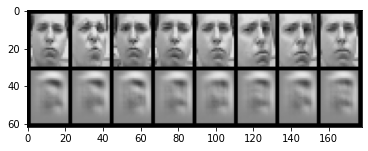

In [17]:
# Нулевая эпоха
image_0 = Image.open('figs/output0.png')
plt.imshow(image_0)

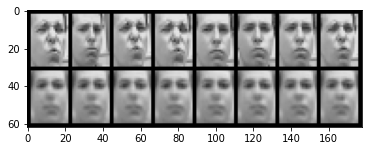

In [18]:
# 10я эпоха
image_10 = Image.open('figs/output10.png')
plt.imshow(image_10)

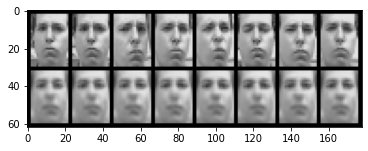

In [19]:
# 19я эпоха
image_19 = Image.open('figs/output19.png')
plt.imshow(image_19)